In [121]:
#Importing standard dependecies
import cv2
import os
import random
import glob
import math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [122]:
#import pytorch dependencies 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [124]:
os.chdir(r"D:\Projects ML\Face Recognition System using DL Proj 11")

In [125]:
#Setting up paths
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

In [9]:
#making directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [33]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [7]:
#Import uuid library to generate unique image names
import uuid

In [8]:
#Establish connection to webcam
cap=cv2.VideoCapture(0)
while cap.isOpened():
    #Read the image
    ret,frame=cap.read()

    #Cutting frame to 250x250 px
    frame=frame[120:120+250,200:200+250,:]

    #Collect anchors
    if cv2.waitKey(1) & 0XFF==ord('a'):
        #Create unique file path
        imgname=os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #Write the image
        cv2.imwrite(imgname,frame)

    #Collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        #Create unique file path
        imgname=os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #Write the image
        cv2.imwrite(imgname,frame)
    
    #Show image back to screen
    cv2.imshow('Image Collection',frame)
    
    #Breaking Gracefully
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break

#Release the webcam
cap.release()
#Close the image
cv2.destroyAllWindows()

In [126]:
anchor_files = [os.path.join(ANC_PATH, f) for f in os.listdir(ANC_PATH)]
positive_files = [os.path.join(POS_PATH, f) for f in os.listdir(POS_PATH)]
negative_files = [os.path.join(NEG_PATH, f) for f in os.listdir(NEG_PATH)]

In [127]:
min_len = min(len(anchor_files), len(positive_files), len(negative_files))

In [128]:
anchor_files = anchor_files[:min_len]
positive_files = positive_files[:min_len]
negative_files = negative_files[:min_len]

In [129]:
positive_pairs = list(zip(anchor_files, positive_files, [1.0]*min_len))
negative_pairs = list(zip(anchor_files, negative_files, [0.0]*min_len))

In [130]:
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

In [131]:
print(f"Total balanced pairs: {len(all_pairs)}")

Total balanced pairs: 840


In [132]:
train_transform = T.Compose([
    T.Resize((100, 100)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2), # Randomize lighting
    T.ToTensor()
])
val_transform = T.Compose([
    T.Resize((100, 100)),
    T.ToTensor()
])

In [133]:
class SiameseDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.pairs[idx]
        
        # Open and Convert
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # Apply Transform
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)

# Re-create loaders with augmentation for training
train_dataset = SiameseDataset(train_data, transform=train_transform)
test_dataset = SiameseDataset(test_data, transform=val_transform) # No augmentation for test

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [134]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # ... (CNN and Embedding parts remain exactly the same) ...
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 10), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 7), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 128, 4), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 4), nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(6400, 4096),
            nn.Sigmoid()
        )
        
        # Classification Layer - CHANGE HERE
        self.classifier = nn.Sequential(
            nn.Linear(4096, 1) 
            # Removed nn.Sigmoid()! We will output raw logits.
        )

        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1) 
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        embedding1 = self.forward_one(input1)
        embedding2 = self.forward_one(input2)
        l1_distance = torch.abs(embedding1 - embedding2)
        output = self.classifier(l1_distance)
        return output

# Re-initialize the model and optimizer after this change
model = SiameseNetwork().to(device)
model._init_weights()

In [135]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [136]:
EPOCHS = 50

In [137]:
for epoch in range(EPOCHS):
    model.train() # Set model to training mode
    running_loss = 0.0
    
    for i, (img1, img2, labels) in enumerate(train_loader):
        # Move data to GPU
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        # 1. Forward Pass
        outputs = model(img1, img2)
        
        # 2. Calculate Loss (Output needs to be squeezed to match label shape)
        loss = criterion(outputs.squeeze(), labels)
        
        # 3. Backward Pass & Optimize
        optimizer.zero_grad() # Clear gradients
        loss.backward()       # Compute gradients
        optimizer.step()      # Update weights
        
        running_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/50], Loss: 0.6388
Epoch [2/50], Loss: 0.4868
Epoch [3/50], Loss: 0.3077
Epoch [4/50], Loss: 0.1658
Epoch [5/50], Loss: 0.1084
Epoch [6/50], Loss: 0.0827
Epoch [7/50], Loss: 0.0655
Epoch [8/50], Loss: 0.0672
Epoch [9/50], Loss: 0.0628
Epoch [10/50], Loss: 0.0559
Epoch [11/50], Loss: 0.0533
Epoch [12/50], Loss: 0.0388
Epoch [13/50], Loss: 0.0417
Epoch [14/50], Loss: 0.0376
Epoch [15/50], Loss: 0.0296
Epoch [16/50], Loss: 0.0349
Epoch [17/50], Loss: 0.0276
Epoch [18/50], Loss: 0.0226
Epoch [19/50], Loss: 0.0183
Epoch [20/50], Loss: 0.0157
Epoch [21/50], Loss: 0.0288
Epoch [22/50], Loss: 0.0404
Epoch [23/50], Loss: 0.0314
Epoch [24/50], Loss: 0.0188
Epoch [25/50], Loss: 0.0145
Epoch [26/50], Loss: 0.0153
Epoch [27/50], Loss: 0.0123
Epoch [28/50], Loss: 0.0120
Epoch [29/50], Loss: 0.0101
Epoch [30/50], Loss: 0.0084
Epoch [31/50], Loss: 0.0144
Epoch [32/50], Loss: 0.0105
Epoch [33/50], Loss: 0.0117
Epoch [34/50], Loss: 0.0106
Epoch [35/50], Loss: 0.0080
Epoch [36/50], Loss: 0.0045
E

In [138]:
from sklearn.metrics import precision_score, recall_score

In [139]:
def evaluate(model, loader, threshold=0.5):
    # Set model to evaluation mode (disables Dropout/BatchNorm training behavior)
    model.eval()
    
    y_true = []
    y_pred = []
    
    # Iterate through the test data
    with torch.no_grad(): # Disable gradient calculation for inference
        for img1, img2, label in loader:
            # Move to device
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            
            # Forward pass
            output = model(img1, img2)
            
            # Store results (move to CPU and convert to numpy)
            y_pred.extend(output.cpu().numpy().flatten())
            y_true.extend(label.cpu().numpy().flatten())
            
    # Binarize predictions
    y_pred_binary = [1 if p > threshold else 0 for p in y_pred]
    
    # Calculate Metrics
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return y_true, y_pred

In [140]:
y_true, y_pred = evaluate(model, test_loader)

Precision: 0.9747
Recall: 1.0000


In [141]:
# 6.4 Visualize Results
# Get a single batch for visualization
# Create an iterator from the loader
data_iter = iter(test_loader)
test_input, test_val, y_true_batch = next(data_iter)

In [142]:
# Move to GPU for prediction
test_input_gpu = test_input.to(device)
test_val_gpu = test_val.to(device)

In [143]:
# Predict
model.eval()
with torch.no_grad():
    y_hat = model(test_input_gpu, test_val_gpu)

In [144]:
# Print raw predictions for the batch
print("\nPredictions for the batch:")
print([1 if p > 0.5 else 0 for p in y_hat.cpu().numpy().flatten()])
print("True Labels:")
print(y_true_batch.numpy().flatten())


Predictions for the batch:
[0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
True Labels:
[0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.]


In [145]:
# Visualization Code (Handling Channel First format of PyTorch)
# PyTorch: (C, H, W) -> Matplotlib: (H, W, C)
def imshow_torch(tensor):
    img = tensor.cpu().numpy().transpose(1, 2, 0) # Change order
    plt.imshow(img)

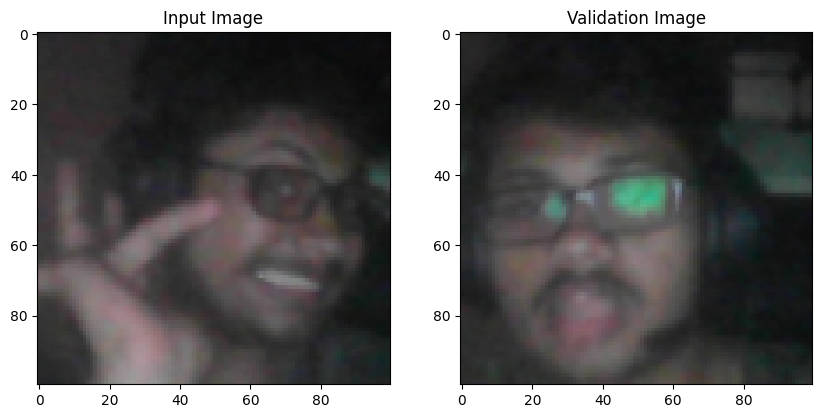

In [146]:
plt.figure(figsize=(10, 8))

# Subplot 1: Input Image
plt.subplot(1, 2, 1)
imshow_torch(test_input[6])
plt.title("Input Image")

# Subplot 2: Validation Image
plt.subplot(1, 2, 2)
imshow_torch(test_val[6])
plt.title("Validation Image")

plt.show()

In [147]:
torch.save(model.state_dict(), "siamese_model.pth")
print("Model Saved Successfully")

Model Saved Successfully


In [148]:
# 7.2 Reload Model
loaded_model = SiameseNetwork().to(device)
loaded_model.load_state_dict(torch.load('siamese_model.pth'))
loaded_model.eval() # Important: Set to eval mode!
print("Model loaded successfully")

Model loaded successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_30084\1665699590.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('siamese_model.pth'))

In [149]:
#Summary
print(loaded_model)

SiameseNetwork(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
  )
)


In [150]:
preprocess = T.Compose([
    T.Resize((100, 100)),
    T.ToTensor()
])

In [151]:
def verify(model, detection_threshold, verification_threshold):
    # Set model to evaluation mode
    model.eval()
    results = []
    
    # Define file paths
    ver_path = os.path.join('application_data', 'verification_images')
    input_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
    
    # Load and process the INPUT image (from webcam)
    # Ensure 3 channels (RGB)
    input_img = Image.open(input_path).convert("RGB") 
    input_tensor = preprocess(input_img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Iterate over every image in the verification folder
        for image_name in os.listdir(ver_path):
            val_path = os.path.join(ver_path, image_name)
            
            # Load and process the VALIDATION image
            val_img = Image.open(val_path).convert("RGB")
            val_tensor = preprocess(val_img).unsqueeze(0).to(device)
            
            # Make Prediction
            logits = model(input_tensor, val_tensor)
            
            # Apply Sigmoid manually (since we removed it from the model)
            pred = torch.sigmoid(logits)
            
            results.append(pred.item())
            
    # Detection Threshold: Metric above which a prediction is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    # Avoid division by zero if folder is empty
    if len(results) == 0:
        return results, False
        
    verification = detection / len(results)
    verified = verification > verification_threshold
    
    return results, verified

In [152]:
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)
os.makedirs(os.path.join('application_data', 'verification_images'), exist_ok=True)

print("Directories created successfully!")

Directories created successfully!


In [157]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
        
    # Crop frame to 250x250 (centering might vary based on webcam resolution)
    # Adjust slicing as per your webcam feed: frame[y:y+h, x:x+w]
    frame_cropped = frame[120:120+250, 200:200+250, :] 
    
    cv2.imshow('Verification', frame_cropped)
    
    # Check key press
    key = cv2.waitKey(10) & 0xFF
    
    # 'v' for Verify
    if key == ord('v'):
        # Save input image
        input_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
        cv2.imwrite(input_path, frame_cropped)
        
        # Run verification
        results, is_verified = verify(loaded_model, 0.5, 0.5)
        print(f"Verified: {is_verified}")
        print(f"Detection Count: {np.sum(np.array(results) > 0.5)}/{len(results)}")
    
    # 'q' to Quit
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Verified: False
Detection Count: 20/50
Verified: True
Detection Count: 47/50
Verified: True
Detection Count: 46/50
Verified: True
Detection Count: 44/50
Verified: True
Detection Count: 50/50
Verified: False
Detection Count: 23/50
Verified: True
Detection Count: 44/50
Verified: True
Detection Count: 43/50


In [158]:
def verify_debug(model):
    model.eval()
    results = []
    
    # Paths
    ver_path = os.path.join('application_data', 'verification_images')
    input_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
    
    # Load Input
    input_img = Image.open(input_path).convert("RGB")
    input_tensor = preprocess(input_img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        for image_name in os.listdir(ver_path):
            val_path = os.path.join(ver_path, image_name)
            val_img = Image.open(val_path).convert("RGB")
            val_tensor = preprocess(val_img).unsqueeze(0).to(device)
            
            logits = model(input_tensor, val_tensor)
            pred = torch.sigmoid(logits)
            results.append(pred.item())
            
    avg_score = np.mean(results)
    print(f"Average Match Score: {avg_score:.4f}")
    print(f"Max Score: {np.max(results):.4f}")
    
    return results

# Capture a stranger's face first, then run:
verify_debug(loaded_model)

Average Match Score: 0.8603
Max Score: 1.0000


[0.9790704250335693,
 0.9830375909805298,
 0.9812387228012085,
 0.9816454648971558,
 0.9843213558197021,
 0.9861380457878113,
 0.9861380457878113,
 0.9775940179824829,
 0.9601803421974182,
 0.961605429649353,
 0.9769982099533081,
 0.9947273135185242,
 0.9920390844345093,
 0.9920390844345093,
 0.998580813407898,
 0.9997981190681458,
 0.9998775720596313,
 0.9998775720596313,
 0.9999501705169678,
 0.99979168176651,
 0.9996991157531738,
 0.12373144924640656,
 0.11215480417013168,
 0.1365814507007599,
 0.1522895246744156,
 0.20809245109558105,
 0.5228747725486755,
 0.854475736618042,
 0.8808594942092896,
 0.9998985528945923,
 0.9994520545005798,
 0.9999527931213379,
 0.999829888343811,
 0.999829888343811,
 0.9994631409645081,
 0.9930023550987244,
 0.9953925609588623,
 0.9988495111465454,
 0.9995219707489014,
 0.9999812841415405,
 0.9996935129165649,
 0.949798583984375,
 0.9640672206878662,
 0.989712119102478,
 0.9743709564208984,
 0.9762632250785828,
 0.9762632250785828,
 0.9015693664550781